# LeNet-5(Tensorflow)

![](../../../picture/177.png)
该模型是原文模型,在C3层以及最后的Gaussian Connections是比较难实现的.我们目前而言对该模型做一些调整:

- 原文sigmoid激活函数,更改为ReLu函数

- C3层依然使用普通采样

- 由于输入为$(32,32)$,Minis数据集为$(28,28)$,所以我们输入层需要padding.

- 输出层我们不再采用Gaussian connection,转而使用softmax.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from utils import random_mini_batche_v2
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Load Dataset

这里使用Keras数据集中的Minist数据集,train set 60K,test set 10K.

这里将样本拆分为: train set 60K,validation set 7K, test set 3K.同时将样本reshape为$(28,28,1)$.

In [2]:
def loadDataset(index,split_rate):
    (x_train,y_train),(X,Y) = mnist.load_data()
    n_classes = 10
    
    plt.imshow(x_train[index],cmap='gray')
    plt.show()
    
    x_train,X = x_train / 255,X/255
    x_val, x_test, y_val, y_test = train_test_split(X, Y, test_size=split_rate)
    
    y_train = np.eye(n_classes)[y_train]
    y_val = np.eye(n_classes)[y_val]
    y_test = np.eye(n_classes)[y_test]
    
    x_train = x_train.reshape((-1,28,28,1))
    x_val = x_val.reshape((-1,28,28,1))
    x_test = x_test.reshape((-1,28,28,1))
    
    print('Training Set shape is:\n',x_train.shape)
    print('Training Labels shape is:\n',y_train.shape)
    print('Validation Set shape is:\n',x_val.shape)
    print('Validation Labels shape is:\n',y_val.shape)
    print('Testing Set shape is:\n',x_test.shape)
    print('Testing Labels shape is:\n',y_test.shape)
    return x_train,y_train,x_val,y_val,x_test,y_test

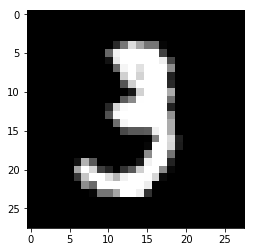

Training Set shape is:
 (60000, 28, 28, 1)
Training Labels shape is:
 (60000, 10)
Validation Set shape is:
 (7000, 28, 28, 1)
Validation Labels shape is:
 (7000, 10)
Testing Set shape is:
 (3000, 28, 28, 1)
Testing Labels shape is:
 (3000, 10)


In [3]:
x_train,y_train,x_val,y_val,x_test,y_test = loadDataset(10,0.3)

## Initialization Parameters

接下来初始化参数,这里只需要初始化CONV layer,由于我们使用的是```tf.contrib.layers.fully_connected```所以并不需要初始化FC层的$Weights,Bias$.

In [4]:
def init_parameters():
    """
    Initialization parameters:
    
    Note:
    ----
        The Weights shape is (f_h,f_w,f_c,f_m), f_c = n_c.
        The bias shape is (1,1,f_m)
    Return:
    ------
        parameters: include weights1,2 and bias1,2.
    """
    init_W = tf.keras.initializers.he_normal(1) # set he normal initialize.
    init_b = tf.zeros_initializer()
    W1 = tf.get_variable('W1',[5,5,1,6],initializer=init_W)
    b1 = tf.get_variable('b1',[1,1,6],initializer=init_b)
    W2 = tf.get_variable('W2',[5,5,6,16],initializer=init_W)
    b2 = tf.get_variable('b2',[1,1,16],initializer=init_b)
    
    parameters = (W1,b1,W2,b2)
    
    return parameters

## Forward

构建Forward Propagation.

网络构成为:

INPUT(batch,32,32,1)-->CONV1(batch,28,28,6)-->Relu1-->Average Pool1(batch,14,14,6)-->CONV2(batch,10,10,16)-->ReLu2-->Average Pool2(5,5,16)-->FC3(batch,120)-->FC4(batch,84)-->FC5(batch,10).


In [5]:
def forward(X,parameters):
    """
    Forward Propagation 
    
    Arguments:
    ---------
        X: training data set, the shape is (batch,n_h,n_w,n_c)
        parameters: include weights and bias ,weights shape is (f_h,f_w,f_c,f_m),bias shape is (1,1,f_m).
    
    Returns:
    -------
        Z5: The output values. Have not use activation function !!!.
    """
    (W1,b1,W2,b2) = parameters
   
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],name='CONV1',padding='VALID') + b1
    A1 = tf.nn.relu(Z1,name='ReLu1')
    P1 = tf.nn.avg_pool(A1,[1,2,2,1],strides=[1,2,2,1],name='Pool1',padding="VALID")
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],name='CONV2',padding="VALID") + b2
    A2 = tf.nn.relu(Z2,name='ReLu2')
    P2 = tf.nn.avg_pool(A2,[1,2,2,1],strides=[1,2,2,1],name='Pool2',padding="VALID")
    
    Flatten = tf.layers.flatten(P2,name='Flatten')
    Z3 = tf.contrib.layers.fully_connected(inputs=Flatten,num_outputs=120)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.contrib.layers.fully_connected(inputs=A3,num_outputs=84)
    A4 = tf.nn.relu(Z4)
    # Must set the activation_fn equal None !!
    Z5 = tf.contrib.layers.fully_connected(inputs=A4,num_outputs=10,activation_fn=None)
    
    return Z5

下面我们来测试一下Forward.首先我们需要将$(28,28)$的输入pad到$(32,32)$,其中pad=2.

In [9]:
tf.reset_default_graph()
with tf.Session() as sess:
    X = tf.placeholder(tf.float32,[None,32,32,1])
    parameters = init_parameters()
    test_X = np.pad(x_train,pad_width=((0,0),(2,2),(2,2),(0,0)),mode='constant')
    print("Input shape is:\n",test_X.shape)
    out = forward(X,parameters)
    sess.run(tf.global_variables_initializer())
    out_shape = sess.run(out,feed_dict={X:test_X}).shape
    print('Output shape is:\n',out_shape)

Input shape is:
 (60000, 32, 32, 1)
Output shape is:
 (60000, 10)


可以看到Forward能够顺利运行.

## Create LeNet-5 Model

下面开始搭建LeNet-5 Model

In [16]:
def LeNet_5Model(data,labels,val_data,val_labels,test_data,test_labels,epochs,lr,BATCH_SIZE):
    """
    Implemention LeNet-5 Module.
    
    Arguments:
    ---------
        data: training data set, the shape is (m,n_h,n_w,n_c).
        labels: training labels, the shape is (m,n_classes).
        val_data: validation data set, the shape is (m,n_h,n_w,n_c).
        val_labels: validation labels, the shape is (m,n_classes).
        test_data: testing data set, the shape is (m,n_h,n_w,n_c).
        test_labels: tesing labels, the shape is (m,n_classes).
        epochs: number of iterate. 
        lr: learning rate to use in RMSProp optimizer.
        BATCH_SIZE: epoch size.
    
    """
    ops.reset_default_graph()
    
    ############################ padding data ####################################
    data = np.pad(data,pad_width=((0,0),(2,2),(2,2),(0,0)),mode='constant')
    val_data = np.pad(val_data,pad_width=((0,0),(2,2),(2,2),(0,0)),mode='constant')
    test_data = np.pad(test_data,pad_width=((0,0),(2,2),(2,2),(0,0)),mode='constant')
    ############################### end of padded ###################################
    
    m,n_h,n_w,n_c = data.shape
    n_classes = labels.shape[1]
    # Create PlaceHolder
    X = tf.placeholder(tf.float32,[None,n_h,n_w,n_c],name='Input')
    y = tf.placeholder(tf.float32,[None,n_classes],name='Labels')
    
    # Forward propagation
    parameters = init_parameters()
    out = forward(X,parameters)
    # Caculate loss.
    Cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,labels=y))
    # Use RMSProp optimizer.
    optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(Cost)
    
    # Caculate accuracy.
    predict = tf.argmax(tf.nn.softmax(out,axis=1),axis=1)
    correct = tf.equal(predict,tf.argmax(y,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
    seed = 0
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        print('Start Training ...')
        for epoch in range(epochs):
            seed += 1
            batchs = random_mini_batche_v2(data,labels,BATCH_SIZE,seed)
            for mini_x,mini_y in batchs:
                
                sess.run(optimizer,feed_dict={X:mini_x,y:mini_y})

            if epoch % 1 == 0:
                acc_train,loss_train = sess.run([accuracy,Cost],feed_dict={X:data,y:labels})
                acc_val,loss_val = sess.run([accuracy,Cost],feed_dict={X:val_data,y:val_labels})
                print('[{}/{}] train loss:{:.4f} train acc:{:.4f} val loss:{:.4f} val acc:{:.4f}'.format(epoch+1,
                                                                                                        epochs,
                                                                                                        loss_train,
                                                                                                        acc_train,
                                                                                                        loss_val,
                                                                                                        acc_val))
        print('Start Testing ...')
        acc_test,loss_test = sess.run([accuracy,Cost],feed_dict={X:test_data,y:test_labels})
        print('\033[0;35m The Testing Set Loss:{:.4f} Accuracy:{:.4f}\033[0m'.format(loss_test,acc_test))

In [17]:
LeNet_5Model(x_train,y_train,x_val,y_val,x_test,y_test,10,lr=1e-4,BATCH_SIZE=100)

Start Training ...
[1/10] train loss:0.4258 train acc:0.8804 val loss:0.4046 val acc:0.8883
[2/10] train loss:0.2671 train acc:0.9226 val loss:0.2554 val acc:0.9267
[3/10] train loss:0.2041 train acc:0.9398 val loss:0.1923 val acc:0.9440
[4/10] train loss:0.1607 train acc:0.9527 val loss:0.1517 val acc:0.9551
[5/10] train loss:0.1318 train acc:0.9613 val loss:0.1281 val acc:0.9616
[6/10] train loss:0.1092 train acc:0.9680 val loss:0.1033 val acc:0.9689
[7/10] train loss:0.1002 train acc:0.9703 val loss:0.0956 val acc:0.9711
[8/10] train loss:0.0858 train acc:0.9747 val loss:0.0801 val acc:0.9769
[9/10] train loss:0.0856 train acc:0.9744 val loss:0.0816 val acc:0.9740
[10/10] train loss:0.0699 train acc:0.9794 val loss:0.0670 val acc:0.9800
Start Testing ...
 The Testing Set Loss:0.0657 Accuracy:0.9813
